# Lunar Lander using DQN

## Imports

In [29]:
import warnings
warnings.filterwarnings("ignore")

import gym
import numpy as np
import torch
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import itertools
import random

import DQNconfig

In [30]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("DQNlogs/")

## Environment 

In [31]:
env = gym.make("LunarLander-v2")
obs = env.reset()
episode_reward = 0.0

## Replay memory

In [32]:
Transition = namedtuple('Transition', ('states', 'actions', 'rewards', 'dones', 'next_states'))

class Replay_memory():

    def __init__(self, env, fullsize, minsize, batchsize):
        self.env = env
        self.memory = deque(maxlen=fullsize)
        self.rewards = deque(maxlen=50)
        self.batchsize = batchsize
        self.minsize = minsize

    def append(self, transition):
        self.memory.append(transition) # append episode to memory 
    
    def sample_batch(self):
        batch = random.sample(self.memory, self.batchsize) # sample the size of batchsize from memory 
        batch = Transition(*zip(*batch)) #tuple of sampled batches 
        states = torch.from_numpy(np.array(batch.states, dtype=np.float32)) # tensor of states
        actions = torch.from_numpy(np.array(batch.actions, dtype=np.int64)).unsqueeze(1) # tensor of actions
        rewards = torch.from_numpy(np.array(batch.rewards, dtype=np.float32)).unsqueeze(1) # tensor of rewards
        dones = torch.from_numpy(np.array(batch.dones, dtype=np.bool8)).unsqueeze(1) # tensor of dones (done is true when the end is reached)
        next_states = torch.from_numpy(np.array(batch.next_states, dtype=np.float32)) # tensor of next states
        return states, actions, rewards, dones, next_states

    def initialize(self):
        obs = env.reset() # restart
        for _ in range(self.minsize):
            action = self.env.action_space.sample() # random action
            new_obs, reward, done, info = env.step(action) # perform action
            transition = Transition(obs, action, reward, done, new_obs)
            self.append(transition)
            obs = new_obs
            if done:
                self.env.reset()
        return self

In [33]:
replay_memory = Replay_memory(env, DQNconfig.BUFFER_SIZE, DQNconfig.MIN_REPLAY_SIZE, DQNconfig.BATCH_SIZE).initialize() # "LunarLander-v2", 10000, 5000, 64

## DQN

In [34]:
class DQN(torch.nn.Module):
    def __init__(self, inputs, outputs):
        super(DQN, self).__init__()
        self.a1 = torch.nn.Linear(inputs, 64)
        self.a2 = torch.nn.Linear(64, outputs)
    
    def forward(self, x):
        output = self.a1(x)
        output = torch.tanh(output) # activation function
        return self.a2(output)
    
    def __call__(self, x):
        return self.forward(x)

dqn_policy = DQN(inputs = env.observation_space.shape[0], outputs = env.action_space.n)
dqn_target = DQN(inputs = env.observation_space.shape[0], outputs = env.action_space.n)
dqn_target.load_state_dict(dqn_policy.state_dict()) # loading policy model into target
print(dqn_target.eval())
loss_fn = torch.nn.SmoothL1Loss()
learning_rate = 0.001
optimizer = torch.optim.Adam(dqn_policy.parameters(), lr=learning_rate)

DQN(
  (a1): Linear(in_features=8, out_features=64, bias=True)
  (a2): Linear(in_features=64, out_features=4, bias=True)
)


In [35]:
def epsilon_greedy_policy(epsilon, obs):
    rnd_sample = random.random()
    if rnd_sample <= epsilon:
        action = env.action_space.sample()
    else:
        with torch.no_grad():
            action = int(torch.argmax(dqn_policy(torch.Tensor(obs))))
    return action

## Training

In [36]:
obs = env.reset()
eps_threshold = DQNconfig.EPS_START
episode = 1

rewards = []
episodes = []
epsilon_values = []
DQN_loss = []

In [37]:
for step in itertools.count():
    action = epsilon_greedy_policy(eps_threshold, obs) # select action from the action space
    new_obs, reward, done, _ = env.step(action) # perform action on env
    replay_memory.append(Transition(obs, action, reward, done, new_obs)) # save episode
    episode_reward += reward # cumulative episode reward
    obs = new_obs
    
    if done: # checking if end of env has been reached
        episode += 1 # move on to next episode 
        eps_threshold = np.max((eps_threshold * DQNconfig.EPS_DECAY, DQNconfig.EPS_END)) # decrease epsilon value
        replay_memory.rewards.append(episode_reward)
        obs = env.reset()
        avg_res = np.mean(replay_memory.rewards) # calculate the average reward over the last 50 eps
        rewards.append(avg_res)
        episodes.append(episode)
        epsilon_values.append(eps_threshold)
        writer.add_scalar("Epsilon", eps_threshold, episode)
        writer.add_scalar("Rewards", reward, episode)

        if episode % 50 == 0: 
            avg_res = np.mean(replay_memory.rewards)
            print(f'Episode: {episode} Avg Results: {avg_res} Epsilon: {eps_threshold}') # print average reward every 50 eps

        if avg_res >= 195:
            print(f'Solved at episode: {episode} Avg Results: {avg_res}') # stop training when average reward is over 195
            break
        
        if step % DQNconfig.TARGET_UPDATE_FREQ == 0:
            dqn_target.load_state_dict(dqn_policy.state_dict()) # update the target based on the policy

        episode_reward = 0 # reset episode reward for next ep

    b_states, b_actions, b_rewards, b_dones, b_next_states = replay_memory.sample_batch() # take random states from previous episodes

    qvalues = dqn_policy(b_states).gather(1, b_actions) # retrieve Q-value
    
    with torch.no_grad(): # updating DQN neural network
        target_qvalues = dqn_target(b_next_states)
        max_target_qvalues = torch.max(target_qvalues, axis=1).values.unsqueeze(1)
        expected_qvalues = b_rewards + DQNconfig.GAMMA * (1 - b_dones.type(torch.int64)) * max_target_qvalues

    loss = loss_fn(qvalues, expected_qvalues) # SmoothL1Loss
    DQN_loss.append(loss)
    optimizer.zero_grad()
    writer.add_scalar("DQN Loss", loss, episode)
    loss.backward() # backpropagate network weights
    for param in dqn_policy.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

writer.flush()
writer.close()

Episode: 50 Avg Results: -123.26510214556163 Epsilon: 0.7822236754458713
Episode: 100 Avg Results: -74.83308218415263 Epsilon: 0.6088145090359074
Episode: 150 Avg Results: -42.91195023413886 Epsilon: 0.4738479773082268
Episode: 200 Avg Results: -4.8687442553337625 Epsilon: 0.36880183088056995
Episode: 250 Avg Results: 14.175447553120877 Epsilon: 0.28704309604425327
Episode: 300 Avg Results: 16.799959825682848 Epsilon: 0.22340924607110255
Episode: 350 Avg Results: 51.401695913361685 Epsilon: 0.17388222158237718
Episode: 400 Avg Results: 80.95622732280566 Epsilon: 0.1353347165085562
Episode: 450 Avg Results: 93.20791463904068 Epsilon: 0.10533270926593409
Episode: 500 Avg Results: 163.59454198853217 Epsilon: 0.08198177029173696
Episode: 550 Avg Results: 169.80344956250795 Epsilon: 0.06380744126877576
Episode: 600 Avg Results: 156.17958070372887 Epsilon: 0.05
Episode: 650 Avg Results: 145.6211045230118 Epsilon: 0.05
Episode: 700 Avg Results: 155.0612697761727 Epsilon: 0.05
Solved at episod

## Evaluation

#### Rewards Graph

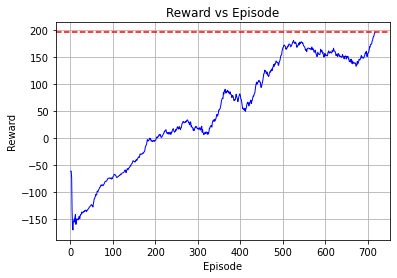

In [38]:
(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('Episode')
ax.set_ylabel('Reward')
ax.set_title('Reward vs Episode')
ax.plot(range(1, len(rewards) + 1), rewards, color='blue', linestyle='-', linewidth=1, label = "Reward")
ax.axhline(y = 195, color = 'r', linestyle = '--')
ax.grid()

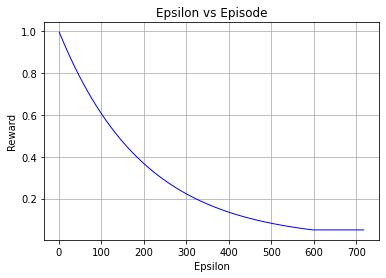

In [39]:
(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('Epsilon')
ax.set_ylabel('Reward')
ax.set_title('Epsilon vs Episode')
ax.plot(range(1, len(epsilon_values) + 1), epsilon_values, color='blue', linestyle='-', linewidth=1, label = "Reward")
ax.grid()

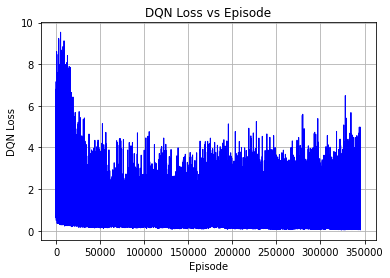

In [40]:
(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('Episode')
ax.set_ylabel('DQN Loss')
ax.set_title('DQN Loss vs Episode')
ax.plot(range(1, len(DQN_loss) + 1), DQN_loss, color='blue', linestyle='-', linewidth=1, label = "Reward")
ax.grid()

In [51]:
from colabgymrender.recorder import Recorder
env = Recorder(env, './video')

In [ ]:
state = env.reset()
done = False
while not terminal:
    with torch.no_grad():
        action = int(torch.argmax(dqn_policy(torch.Tensor(obs))))
        obs, reward, terminal, info = env.step(action)
env.play()